# Training VGG11 on CIFAR-10

### Load and normalizing the CIFAR10 training and test datasets using torchvision

In [12]:
# Loading and normalizing CIFAR-10
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
!pip install torchsummary
from torchsummary import summary

In [13]:
transform = transforms.Compose( #transforms 함수 미리 정의
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#위의 normalize는 는 image = (image - mean) / std 를 시켜줌. 3 개인 이유는 각 채널마다 mean, std를 적용시켜야 되기 때문. 
#input value [0,1] -> [-1, 1] range로 바뀜. 예를 들어서, minimum value 0은 (0-0.5)/0.5 = -1, maximum value 1은 (1-0.5)/0.5 = 1 이 된다.

batch_size = 8
#load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, #torchvision의 dataset에서 CIFAR10 dataset다운 받음. 
                                      download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
#define dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


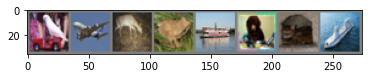

 bird plane  deer  frog  ship   dog   cat  ship


In [14]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Define VGG11

* Conv – input channels: 3, output channels: 64
* Maxpooling 
* Conv – input channels: 64, output channels: 128
* Maxpooling 
* Conv – input channels: 128, output channels: 256
* Conv – input channels: 256, output channels: 256
* Maxpooling 
* Conv – input channels: 256, output channels: 512
* Conv – input channels: 512, output channels: 512
* Maxpooling 
* Conv – input channels: 512, output channels: 512
* Conv – input channels: 512, output channels: 512
* Maxpooling
* FC

In [15]:
### implement vgg11 model
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.conv1 = self.make_conv_relu(3, 64)
        
        self.conv2 = self.make_conv_relu(64, 128)
        
        self.conv3_1 = self.make_conv_relu(128, 256)
        self.conv3_2 = self.make_conv_relu(256, 256)
        
        self.conv4_1 = self.make_conv_relu(256, 512)
        self.conv4_2 = self.make_conv_relu(512, 512)
        
        self.conv5_1 = self.make_conv_relu(512, 512)
        self.conv5_2 = self.make_conv_relu(512, 512)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        self.fc = nn.Linear(in_features = 512 * 1 * 1 , out_features = 10)
        
    def make_conv_relu(self, in_channels, out_channels):
        layers = []
        layers += [nn.Conv2d(
            in_channels, out_channels, kernel_size = 3, stride = 1, padding = "same"), 
                  nn.ReLU()]
        return nn.Sequential(*layers)
        
    def forward(self, x):
        # input x : [batch, 3, 32, 32]
        x = self.conv1(x) # [batch, 64, 32, 32]
        x = self.maxpool(x) # [batch, 64, 16, 16]
        
        x = self.conv2(x) # [batch, 128, 16, 16]
        x = self.maxpool(x) # [batch, 128, 8, 8]
        
        x = self.conv3_1(x) # [batch, 256, 8, 8]
        x = self.conv3_2(x) # [batch, 256, 8, 8]
        x = self.maxpool(x) # [batch, 256, 4, 4]
        
        x = self.conv4_1(x) # [batch, 512, 4, 4]
        x = self.conv4_2(x) # [ batch, 512, 4, 4]
        x = self.maxpool(x) # [batch, 512, 2, 2]
        
        x = self.conv5_1(x) # [batch, 512, 2, 2]
        x = self.conv5_2(x) # [batch, 512, 2, 2]
        x = self.maxpool(x) # [batch, 512, 1, 1]
        
        # flatten
        x = x.view(-1, 512* 1*1 ) #[batch, 512]
        x = self.fc(x) # [batch, 10]
        
        return x

In [16]:
net = VGG11()
net.train()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

summary(net, batch_size=-1, input_size=(3, 32, 32), device='cuda')

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            

### Define a Loss function and optimizer
* Use Classification Cross-Entropy loss
* Use Adam with learning rate 0.0001 

In [17]:
import torch.optim as optim

# define a loss and optimizer
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss에 softmax까지 구현되어있기 때문에 모델에 softmax를 선언하지 않아도 됨. 
optimizer = optim.Adam(net.parameters(), lr=0.0001)

### Train the network on the training data

In [18]:
### Train the network
print('Start Training ')
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Fill this loop
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # print statistics
        if i % 500 == 499:
            print("epoch: {}, iter: {}, loss: {:.3f}".format(epoch+1, i+1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

Start Training 
epoch: 1, iter: 500, loss: 2.077
epoch: 1, iter: 1000, loss: 1.869
epoch: 1, iter: 1500, loss: 1.747
epoch: 1, iter: 2000, loss: 1.641
epoch: 1, iter: 2500, loss: 1.569
epoch: 1, iter: 3000, loss: 1.515
epoch: 1, iter: 3500, loss: 1.469
epoch: 1, iter: 4000, loss: 1.355
epoch: 1, iter: 4500, loss: 1.365
epoch: 1, iter: 5000, loss: 1.285
epoch: 1, iter: 5500, loss: 1.255
epoch: 1, iter: 6000, loss: 1.209
epoch: 2, iter: 500, loss: 1.125
epoch: 2, iter: 1000, loss: 1.120
epoch: 2, iter: 1500, loss: 1.080
epoch: 2, iter: 2000, loss: 1.056
epoch: 2, iter: 2500, loss: 1.000
epoch: 2, iter: 3000, loss: 1.038
epoch: 2, iter: 3500, loss: 0.971
epoch: 2, iter: 4000, loss: 0.967
epoch: 2, iter: 4500, loss: 0.946
epoch: 2, iter: 5000, loss: 0.940
epoch: 2, iter: 5500, loss: 0.908
epoch: 2, iter: 6000, loss: 0.890
Finished Training


### Test the network on the test data

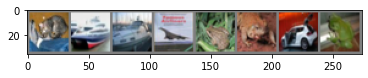

GrondTruth:    cat  ship  ship plane  frog  frog   car  frog


In [19]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [20]:
images = images.cuda()
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size))) 


Predicted:    cat  ship  ship plane  frog  frog   car  deer


In [21]:
# Let us look at how the network performs on the whole dataset

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 76 %
Accuracy of  bird : 63 %
Accuracy of   cat : 40 %
Accuracy of  deer : 78 %
Accuracy of   dog : 32 %
Accuracy of  frog : 75 %
Accuracy of horse : 70 %
Accuracy of  ship : 84 %
Accuracy of truck : 78 %
